## Vertex reconstruction in a large Directional Liquid Scintillator Detector
Training data location: https://stash.osgconnect.net/public/elagin/vtx_dir_1el_norm/

Testing data location: https://stash.osgconnect.net/public/elagin/test_vtx_dir_1el_norm/

Data are .npz files with 3 numpy arrays. Where each row correspond to one event.

"x" is a (1000,6300) array of "independent variables", photo-electron hits (theta, phi, and time). Hit coordinate encoding in each row is the folowing: \
theta = x[:,0::3] \
phi = x[:,1::3] \
time = x[:,2::3] \
All data is normalized as theta = theta/pi, phi = phi/(2pi), time = time/maxT (currently maxT=150). \
Each row in "x" is padded with -1 to make it a length of 6300 

"y_vtx" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the event vertex to be reconstructed \
"y_dir" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the unit vector along the original direction of the electron

See checking_inputs.ipynb and checking_inputs_norm.ipynb for more details on the data

In [1]:
import os
import math

import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import random

In [2]:

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda, Input, Concatenate, concatenate
from keras.layers import Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling1D, MaxPooling2D, LocallyConnected2D, LocallyConnected1D
from keras.layers import LSTM, Bidirectional
from keras.layers import Masking
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [3]:
#global variables
maxT = 37
maxLambda = 800
PAD_VALUE = -1
NEvts = 1000
pi = 3.141592653589793
NFiles = 100

### Custom generator to load large datasets

In [4]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences

class MyGenerator(Sequence):
    def __init__(self, x_dir, batch_size):
        self.x_dir = x_dir
        self.x = os.listdir(x_dir)
        self.batch_size = batch_size
        print('Generator init complete')
        
    def __len__(self):
        nf = self.batch_size/(NEvts) # calculate number of files
        return math.ceil(len(self.x) / nf)

    def __getitem__(self, idx):
        batch_data = np.load(os.path.join(self.x_dir, self.x[idx]))
        Y = np.array(batch_data['y_vtx'])
        return np.array(batch_data['x']), Y

In [22]:
training_generator = MyGenerator('/data/Elagin/vtx_dir_1el_color_norm', NEvts)

#testing_generator = MyGenerator('/data/Elagin/test_vtx_dir_1el_color_norm', NEvts)

Generator init complete


### Loading data that can fit into RAM

In [6]:
# Load data from x_dir, stop after loading fn_max files
# Returns X, Y, Dir
# X - independent variables
# Y - dependend variables (x-, y-, z- of the vertex in this implementation)
# Dir - direction vector (x-, y-, z- componenets), could be made dependent variable
def load_test_data_to_memory(x_dir, fn_max=2000) :
    X, Y, Dir = np.array([]), np.array([]), np.array([])
    f_list = os.listdir(x_dir)
    f_list.sort()
    i=0
    for x in f_list :
        batch_data = np.load(os.path.join(x_dir, x))
        
        X = np.vstack([X, np.array(batch_data['x'])]) if X.size else np.array(batch_data['x'])
        Y = np.vstack([Y, np.array(batch_data['y_vtx'])]) if Y.size else np.array(batch_data['y_vtx'])
        Dir = np.vstack([Dir, np.array(batch_data['y_dir'])]) if Dir.size else np.array(batch_data['y_dir'])

        i+=1
        if i%10 == 0:
            print(x)
            print('i = ', i, '   ', X.shape, '   ', Y.shape, '   ', Dir.shape)
        if i>=fn_max:
            break
    print(X.shape, '   ', Y.shape, '   ', Dir.shape)
    return X, Y, Dir

In [7]:
testX, testY, trueDir = load_test_data_to_memory('/data/Elagin/test_vtx_dir_1el_color_norm/')

f_batch_18.npz
i =  10     (10000, 8400)     (10000, 3)     (10000, 3)
f_batch_27.npz
i =  20     (20000, 8400)     (20000, 3)     (20000, 3)
f_batch_36.npz
i =  30     (30000, 8400)     (30000, 3)     (30000, 3)
f_batch_45.npz
i =  40     (40000, 8400)     (40000, 3)     (40000, 3)
(49000, 8400)     (49000, 3)     (49000, 3)


In [9]:
#trainX, trainY, trueDir_training = load_test_data_to_memory('/data/Elagin/vtx_dir_1el_norm/',200)

### Defining various activation functions

In [8]:
def mapping_to_pmOne(x) :
    return 2*K.sigmoid(x) - 1

def mapping_to_pm50(x) :
    return mapping_to_pmOne(x)*50

def mapping_to_pm300(x) :
    return mapping_to_pmOne(x)*300

def mapping_to_0_50(x) :
    return 50*K.sigmoid(x)


def mapping_to_target_range_all( x, target_min=-0.02*pi, target_max=2.02*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

def mapping_to_target_range_2pi( x, target_min=-0.00*pi, target_max=2.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_pi( x, target_min=-0.00*pi, target_max=1.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_phi( x, target_min=0, target_max=2*pi ) :
    print('is x keras tensor:', K.is_keras_tensor(x))
    print('x shape = ',K.int_shape(x))
    print('x shape = ',K.shape(x))
    #phi = K.placeholder(shape=(None,1))
    phi = Input([1])
    #theta = K.placeholder(shape=(None,1))
    theta = Input([1])
    #r = K.placeholder(shape=(None,1))
    r = Input([1])
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    phi = K.concatenate([phi, [K.tanh(x[:,1]) + 1]], axis=0) # x in range(0,2)
    #phi = K.tanh(x[:,1]) + 1
    theta = K.concatenate([theta, [x[:,0]]], axis=0)
    #theta = x[:,0]
    r = K.concatenate([r, [x[:,2]]], axis=0)
    #r = x[:,2]
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    print('theta shape = ',K.int_shape(theta))
    print('r shape = ',K.int_shape(r))
    scale = ( target_max-target_min )/2.
    phi =  phi * scale + target_min
    #phi = K.cast(phi, dtype='int32')
    #phi = K.reshape(phi, (,1))
    print('phi shape = ',K.int_shape(phi))
    
    res = K.concatenate([theta, phi, r], axis=1)
    print('res shape = ',K.int_shape(res))
    print('res shape = ',K.shape(res))
    print('is res keras tensor:', K.is_keras_tensor(res))
    x[:,1].assign(phi)
    return x

def mapping_to_target_range_phi2( x, target_min=0, target_max=2*pi ) :
    scale = ( target_max-target_min )/2.
    phi = K.placeholder(shape=(None,1))
    #phi = Input([1])
    #phi = (K.tanh(x[:,1]) + 1)*scale + target_min
    phi = K.concatenate([phi, [(K.tanh(x[:,1]) + 1)*scale + target_min]], axis=0)
    x[:,1].assign(phi)
    return x

### The model

In [9]:
def createModel():
    N=8400
    lstm_seq = 400
    lstm_steps = int(N/lstm_seq)
    model = Sequential()
    
    model.add(Reshape(input_shape=(N,), target_shape=(lstm_steps,lstm_seq)))
    
    model.add(Masking(mask_value=-1, input_shape=(lstm_steps, lstm_seq)))
    
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(3, activation=mapping_to_pm300))
#    model.add(Dense(3, activation=None))
    
    return model

In [10]:
my_network=createModel()

In [11]:
my_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 400)           0         
_________________________________________________________________
masking (Masking)            (None, 21, 400)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 75)            142800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 75)            4

### Run the model

In [ ]:
batch_size = NEvts
epochs = 200

def mean_abs_theta_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,0] - y_pred[:,0]))
def mean_abs_phi_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,1] - y_pred[:,1]))
def mean_abs_r_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,2] - y_pred[:,2]))
def mean_abs_theta_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,3] - y_pred[:,3]))
def mean_abs_phi_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,4] - y_pred[:,4]))

def loss_by_R_square(y_true, y_pred):
    return K.mean(K.square(y_true[:,0] - y_pred[:,0])+
                  K.square(y_true[:,1] - y_pred[:,1])+
                  K.square(y_true[:,2] - y_pred[:,2]) )

my_network.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error')#, 
                                            #loss = loss_by_R_square)
                   #metrics=['mean_squared_error', mean_abs_theta_vtx, mean_abs_phi_vtx, mean_abs_r_vtx])#, 
                                                  #mean_abs_theta_dir, mean_abs_phi_dir])

my_network.load_weights("weights_vtx_dir_1el_color_7xLSTM75_8400_400_f950_lr1e-5_N3.h5")
#my_network.load_weights("weights_vtx_dir_1el_2xLSTM75_6300_300_f1930_lr1e-5_N9.h5")


history = my_network.fit_generator(generator=training_generator, epochs=epochs, validation_data=(testX, testY)) 

#history = my_network.fit(trainX, trainY, batch_size=1000, epochs=epochs, verbose=1, validation_data=(testX, testY))


Epoch 1/200
950/950 [==============================] - 378s 397ms/step - loss: 280.6609 - val_loss: 269.6659
Epoch 2/200
950/950 [==============================] - 363s 382ms/step - loss: 265.2459 - val_loss: 260.0576
Epoch 3/200
950/950 [==============================] - 361s 381ms/step - loss: 251.8388 - val_loss: 249.5593
Epoch 4/200
950/950 [==============================] - 363s 382ms/step - loss: 239.8563 - val_loss: 232.0453
Epoch 5/200
950/950 [==============================] - 364s 383ms/step - loss: 229.3490 - val_loss: 222.4398
Epoch 6/200
950/950 [==============================] - 369s 388ms/step - loss: 219.8973 - val_loss: 212.4655
Epoch 7/200
950/950 [==============================] - 368s 387ms/step - loss: 211.6533 - val_loss: 203.4717
Epoch 8/200
950/950 [==============================] - 358s 377ms/step - loss: 203.5154 - val_loss: 199.2316
Epoch 9/200
950/950 [==============================] - 372s 391ms/step - loss: 196.6299 - val_loss: 191.9629
Epoch 10/200
950/95

In [24]:
my_network.save_weights("weights_vtx_dir_1el_color_7xLSTM75_8400_400_f950_lr1e-5_N3.h5")
#my_network.save_weights("weights_dir_1el_7xLSTM75_6300_300_f1930_lr1e-5_N3.h5")

Text(0.5, 1.0, 'Loss Curves')

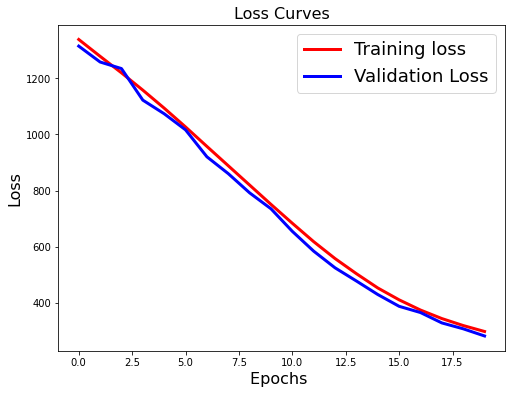

In [25]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [26]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)

dY = recoY - testY
dY0 = recoY[:,0] - testY[:,0]
dY1 = recoY[:,1] - testY[:,1]
dY2 = recoY[:,2] - testY[:,2]
dR = np.sqrt((recoY[:,0] - testY[:,0])*(recoY[:,0] - testY[:,0]) + (recoY[:,1] - testY[:,1])*(recoY[:,1] - testY[:,1]) + (recoY[:,2] - testY[:,2])*(recoY[:,2] - testY[:,2]) )
print(dR.shape, '  dR_mean = ', np.mean(dR))
R_true = np.sqrt(testY[:,0]*testY[:,0] + testY[:,1]*testY[:,1] + testY[:,2]*testY[:,2])
print(R_true.shape)
print(testY.shape)

print('dY: ',dY[0:3,:])
dRb = dR.reshape(dR.shape[0],1)
dY = dY/dRb
print('dY_norm: ',dY[0:3,:])
#np.random.shuffle(trueDir)
vtx_dot_dir = np.sum(dY*trueDir, axis=1)
print(vtx_dot_dir.shape)

shape recoY =  (49000, 3)    shape testY =  (49000, 3)
(49000,)   dR_mean =  24.767579069299565
(49000,)
(49000, 3)
dY:  [[ 12.60573979  -3.90058262  15.43843808]
 [ 35.05383482  -4.77434702  -2.68726029]
 [ 58.15904439  31.31687517 -11.72394063]]
dY_norm:  [[ 0.62069036 -0.19205966  0.76016877]
 [ 0.98800558 -0.13456677 -0.07574145]
 [ 0.86691913  0.46680956 -0.17475714]]
(49000,)


Text(0.5, 0, 'Dot product between Vtx(bias) and Dir(el)')

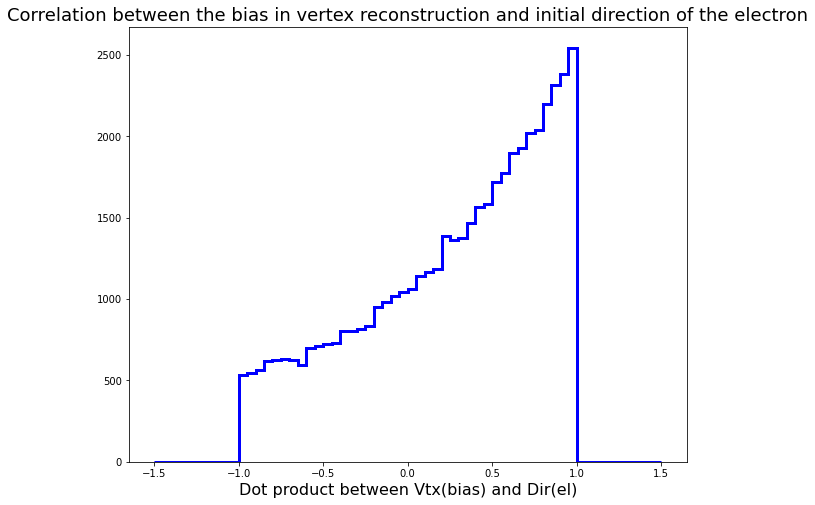

In [27]:
plt.figure(figsize=[10,8])
plt.hist(vtx_dot_dir, bins=60, range=(-1.5,1.5), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.title('Correlation between the bias in vertex reconstruction and initial direction of the electron', fontsize=18)
plt.xlabel('Dot product between Vtx(bias) and Dir(el)', fontsize=16)

MSE =  281.91191025242927
MSE2 =  281.91191025242927
dY0_Mean_vtx =  0.029162671819212976    dY1_Mean_vtx =  -0.1725259393034201    dY2_Mean_vtx =  0.376003992282132
dY0_Rms_vtx =  24.27325435909161     dY1_Rms_vtx =  12.086037829759846     dY2_Rms_vtx =  10.51059195068203
resolution_vtx =  29.081535907810782
reco_Y1_vtx =  [  84.49395   88.48078  -72.4293  ...  219.22119 -146.97298 -161.26085]
test_Y1_vtx =  [  88.39453251   93.25512858 -103.74617358 ...  230.03334988 -132.16106189
 -161.36515737]


Mean_true_vtx_0 =  -0.017212440378999622    Mean_true_vtx_1 =  -0.13439329235465924 Mean_true_vtx_2 =  -0.38149330600135595
RMS_true_vtx_0 =  134.67199293740322    RMS_true_vtx_1 =  134.31360863221246   RMS_true_vtx_2 =  133.98002991737084


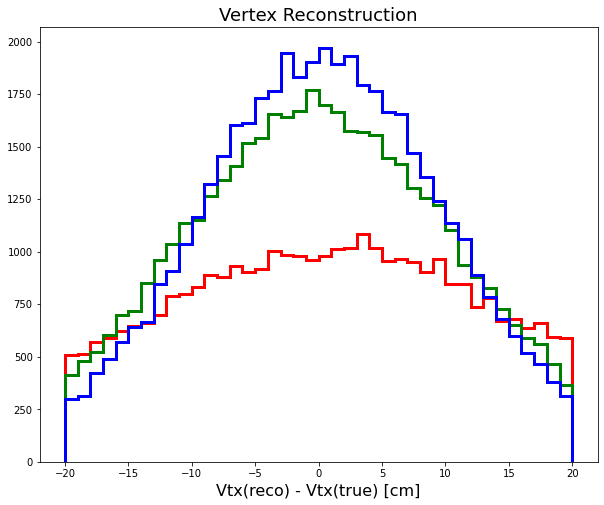

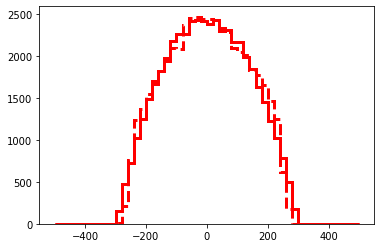

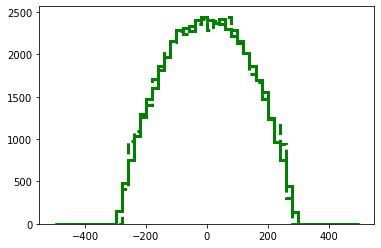

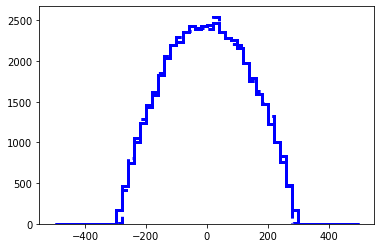

In [28]:
MSE = np.mean( (recoY.flatten()[:] - testY.flatten()[:])*(recoY.flatten()[:] - testY.flatten()[:]) )
print('MSE = ', MSE)

#MSE2 = np.mean(np.square(recoY - testY), axis=-1)
MSE2 = np.mean(np.square(recoY.flatten()[:] - testY.flatten()[:]), axis=-1)
print('MSE2 = ', MSE2)

#dTheta_dir = recoY[:,3] - testY[:,3]
#dPhi_dir = recoY[:,4] - testY[:,4]
print('dY0_Mean_vtx = ' ,np.mean(dY0), '   dY1_Mean_vtx = ', np.mean(dY1), '   dY2_Mean_vtx = ' ,np.mean(dY2))
print('dY0_Rms_vtx = ',np.sqrt(np.mean(np.square(dY0))), '    dY1_Rms_vtx = ',np.sqrt(np.mean(np.square(dY1))), '    dY2_Rms_vtx = ',np.sqrt(np.mean(np.square(dY2))))
print('resolution_vtx = ', np.sqrt(np.mean(np.square(dY0)) + np.mean(np.square(dY1)) + np.mean(np.square(dY2)) ) )
#print('ThetaMean_dir = ',np.mean(dTheta_dir),'   PhiMean_dir = ',np.mean(dPhi_dir))
#print('ThetaRms_dir = ',np.sqrt(np.mean(np.square(dTheta_dir))), '   PhiRms_dir = ',np.sqrt(np.mean(np.square(dPhi_dir))))

print('reco_Y1_vtx = ',recoY[:,1])
print('test_Y1_vtx = ',testY[:,1])
print('')
print('')


#fig_scatt = plt.figure()
#plt.scatter(R_true, dR)

fig_dYs = plt.figure(figsize=[10,8])
plt.hist(dY0, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.hist(dY1, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
plt.hist(dY2, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.title('Vertex Reconstruction',fontsize=18)
plt.xlabel('Vtx(reco) - Vtx(true) [cm]',fontsize=16)

fig_Y0s = plt.figure()
plt.hist(recoY[:,0], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
fig_Y1s = plt.figure()
plt.hist(recoY[:,1], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
fig_Y2s = plt.figure()
plt.hist(recoY[:,2], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
plt.hist(testY[:,2], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')

print('Mean_true_vtx_0 = ', np.mean(testY[:,0]), '   Mean_true_vtx_1 = ' , np.mean(testY[:,1]), 'Mean_true_vtx_2 = ', np.mean(testY[:,2]))
print('RMS_true_vtx_0 = ' , np.sqrt(np.mean(np.square(testY[:,0]))), '   RMS_true_vtx_1 = ' , np.sqrt(np.mean(np.square(testY[:,1]))), '  RMS_true_vtx_2 = ', np.sqrt(np.mean(np.square(testY[:,2]))) )

shape recoY =  (49000, 3)    shape testY =  (49000, 3)
ThetaMean_vtx =  -0.8499771413797286


(array([584., 637., 569., 626., 596., 596., 627., 594., 617., 587., 581.,
        592., 603., 663., 612., 568., 657., 626., 579., 605.]),
 array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
          5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 [<matplotlib.patches.Polygon at 0x7f9a6077d460>])

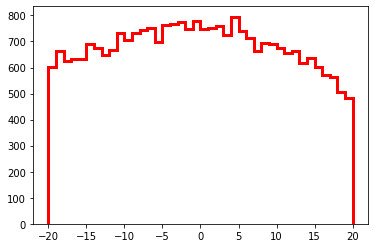

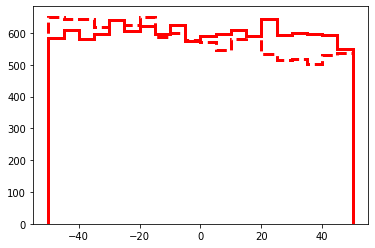

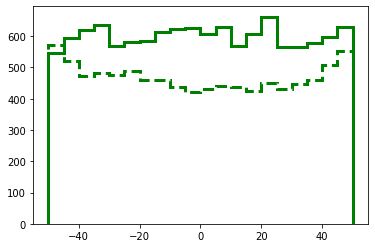

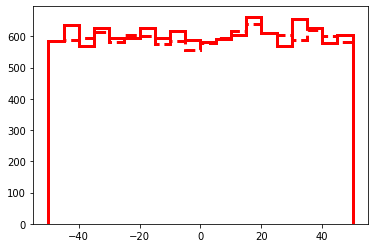

In [18]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)


dTheta_vtx = recoY[:,1] - testY[:,1]
print('ThetaMean_vtx = ',np.mean(dTheta_vtx))

fig1 = plt.figure()
plt.hist(dTheta_vtx, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_sinT = plt.figure()
plt.hist(recoY[:,0], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_cosT = plt.figure()
plt.hist(recoY[:,1], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')

fig_sinP = plt.figure()
plt.hist(recoY[:,2], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,2], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

#fig_cosP = plt.figure()
#plt.hist(recoY[:,3], bins=20, range=(-12,12), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
#plt.hist(testY[:,3], bins=20, range=(-12,12), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')


#fig_R = plt.figure()
#plt.hist(np.abs(recoY[:,4]), bins=20, range=(0,60), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
#plt.hist(testY[:,4], bins=20, range=(0,60), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')


In [ ]:
my_network.summary()